In [2]:
%matplotlib inline
from os.path import expanduser, join
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from sklearn.externals import joblib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

from pyrallel.ensemble import EnsembleGrower
from pyrallel.ensemble import sub_ensemble

In [3]:
from IPython.parallel import Client
lb_view = Client().load_balanced_view()
len(lb_view)

95

## Loading the dataset

This is a NumPy array version of Fold1 of the [MSLR-WEB10K](http://research.microsoft.com/en-us/projects/mslr/) dataset.

In [5]:
%%time

data = np.load(expanduser('~/data/MSLR-WEB10K/mslr-web10k_fold1.npz'))
X_train, y_train, qid_train = data['X_train'], data['y_train'], data['qid_train']
X_vali, y_vali, qid_vali = data['X_vali'], data['y_vali'], data['qid_vali']
X_test, y_test, qid_test = data['X_test'], data['y_test'], data['qid_test']

CPU times: user 3.82 s, sys: 960 ms, total: 4.78 s
Wall time: 15.4 s


Total size in bytes, total number of search results and number of queries:

In [6]:
(X_train.nbytes + X_vali.nbytes + X_test.nbytes) / 1e6

652.904448

In [7]:
len(X_train) + len(X_vali) + len(X_test)

1200192

In [8]:
len(np.unique(qid_train)) + len(np.unique(qid_vali)) + len(np.unique(qid_test))

10000

Concatenate the training and validation sets as a big development set.

In [9]:
X_dev = np.vstack([X_train, X_vali])
y_dev = np.concatenate([y_train, y_vali])
qid_dev = np.concatenate([qid_train, qid_vali])

In [10]:
X_dev.shape

(958671, 136)

In [11]:
X_dev.dtype

dtype('float32')

Extract a subset of 500 queries to speed up the learning when prototyping

In [12]:
def subsample(X, y, qid, size, seed=None):
    rng = np.random.RandomState(seed)
    unique_qid = np.unique(qid)
    qid_mask = rng.permutation(len(unique_qid))[:size]
    subset_mask = np.in1d(qid_train, unique_qid[qid_mask])
    return X[subset_mask], y[subset_mask], qid[subset_mask]


X_train_small, y_train_small, qid_train_small = subsample(
    X_train, y_train, qid_train, 500, seed=0)

In [13]:
X_train_small.shape

(62244, 136)

Sanity check:

In [14]:
len(np.unique(qid_train_small))

500

In [37]:
X_train_medium, y_train_medium, qid_train_medium = subsample(
    X_train, y_train, qid_train, 1000, seed=0)

In [15]:
def balance_irrelevant(X, y, qid, seed=None):
    """Subsample the zero-scored entries"""
    rng = np.random.RandomState(seed)
    unique_qid = np.unique(qid)
    final_mask = np.ones(shape=y.shape, dtype=np.bool)
    for this_qid in unique_qid:
        this_mask = qid == this_qid
        this_y = y[this_mask]
        relevant = this_y >= 2
        ratio = float(np.mean(relevant))
        if ratio > 0.5:
            # already balanced
            continue
            
        final_mask[this_mask] = np.logical_or(
            relevant, np.random.random(len(this_y)) > 0.7) 
    return X[final_mask], y[final_mask], qid[final_mask]

X_balanced_small, y_balanced_small, qid_balanced_small = balance_irrelevant(
    X_train_small, y_train_small, qid_train_small)

In [16]:
print(len(y_train_small))
print(len(y_balanced_small))

62244
25307


## Quantifying ranking success with NDCG

In [17]:
def dcg(relevances, rank=10):
    """Discounted cumulative gain at rank (DCG)"""
    relevances = np.asarray(relevances)[:rank]
    n_relevances = len(relevances)
    if n_relevances == 0:
        return 0.

    discounts = np.log2(np.arange(n_relevances) + 2)
    return np.sum(relevances / discounts)
 
 
def ndcg(relevances, rank=10):
    """Normalized discounted cumulative gain (NDGC)"""
    best_dcg = dcg(sorted(relevances, reverse=True), rank)
    if best_dcg == 0:
        return 0.

    return dcg(relevances, rank) / best_dcg

In [18]:
ndcg([2, 4, 0, 1, 1, 0, 0], rank=5)

0.86253003992915656

In [19]:
ndcg([0, 0, 0, 1, 1, 2, 4], rank=5)

0.13201850690866795

In [20]:
ndcg([0, 0, 0, 1, 1, 2, 4], rank=3)

0.0

In [21]:
ndcg([4, 2, 1, 1, 0, 0, 0], rank=5)

1.0

In [22]:
def mean_ndcg(y_true, y_pred, query_ids, rank=10):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    query_ids = np.asarray(query_ids)
    # assume query_ids are sorted
    ndcg_scores = []
    previous_qid = query_ids[0]
    previous_loc = 0
    for loc, qid in enumerate(query_ids):
        if previous_qid != qid:
            chunk = slice(previous_loc, loc)
            ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
            ndcg_scores.append(ndcg(ranked_relevances, rank=rank))
            previous_loc = loc
        previous_qid = qid

    chunk = slice(previous_loc, loc + 1)
    ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
    ndcg_scores.append(ndcg(ranked_relevances, rank=rank))
    return np.mean(ndcg_scores)


mean_ndcg([4, 3, 1, 4, 3], [4, 0, 1, 4, 2], [0, 0, 0, 2, 2], rank=10)

0.9795191506818377

In [23]:
def print_evaluation(model, X, y, qid):
    tic = time()
    y_predicted = model.predict(X)
    prediction_time = time() - tic
    print("Prediction time: {:.3f}s".format(prediction_time))
    print("NDCG@5 score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=5)))
    print("NDCG@10 score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=10)))
    print("NDCG score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=None)))
    print("R2 score: {:.3f}".format(r2_score(y, y_predicted)))

In [24]:
def plot_ndcg_by_trees(model, X, y, qid, rank=10):
    max_n_trees = len(model.estimators_)
    scores = []
    
    if hasattr(model, 'staged_predict'):
        # stage-wise score computation for boosted ensembles
        n_trees = np.arange(max_n_trees) + 1
        for y_predicted in model.staged_predict(X):
            scores.append(mean_ndcg(y, y_predicted, qid, rank=10))
    else:
        # assume forest-type of tree ensemble: use a log scale to speedup
        # the computation
        # XXX: partial predictions could be reused
        n_trees = np.logspace(0, np.log10(max_n_trees), 10).astype(int)
        for j, n in enumerate(n_trees):
            y_predicted = sub_ensemble(model, n).predict(X)
            scores.append(mean_ndcg(y, y_predicted, qid, rank=rank))
            
    plt.plot(n_trees, scores)
    plt.xlabel("Number of trees")
    plt.ylabel("Average NDCG@%d" % rank)
    _ = plt.title("Impact of the number of trees")

In [25]:
%%time

from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
etr.fit(X_train_small, y_train_small)

CPU times: user 28min 11s, sys: 1.01 s, total: 28min 12s
Wall time: 57 s


In [26]:
print_evaluation(etr, X_test, y_test, qid_test)

Prediction time: 1.117s
NDCG@5 score: 0.470
NDCG@10 score: 0.478
NDCG score: 0.730
R2 score: 0.136


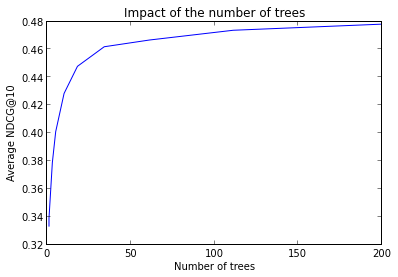

In [27]:
plot_ndcg_by_trees(etr, X_test, y_test, qid_test)

In [136]:
%%time

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
rfr.fit(X_balanced_small, y_balanced_small)

CPU times: user 8min 24s, sys: 172 ms, total: 8min 25s
Wall time: 46.4 s


In [137]:
print_evaluation(rfr, X_test, y_test, qid_test)

Prediction time: 1.555s
NDCG@5 score: 0.476
NDCG@10 score: 0.486
NDCG score: 0.733
R2 score: -0.010


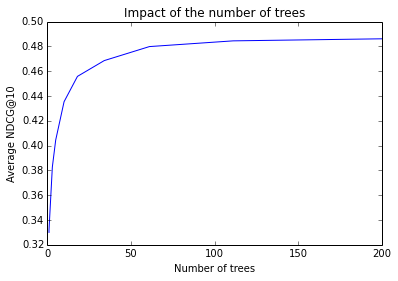

In [138]:
plot_ndcg_by_trees(rfr, X_test, y_test, qid_test)

In [139]:
%%time

from sklearn.ensemble import RandomForestRegressor

rfr2 = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
rfr2.fit(X_train_small, y_train_small)

CPU times: user 24min 21s, sys: 512 ms, total: 24min 21s
Wall time: 2min 18s


In [140]:
#rfr.set_params(n_jobs=-1)
print_evaluation(rfr2, X_test, y_test, qid_test)

Prediction time: 1.644s
NDCG@5 score: 0.484
NDCG@10 score: 0.493
NDCG score: 0.734
R2 score: 0.142


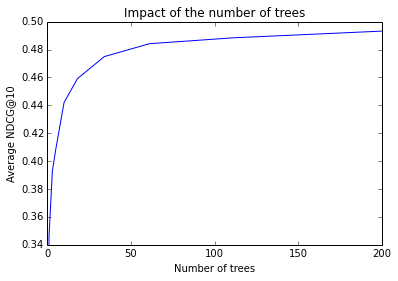

In [141]:
plot_ndcg_by_trees(rfr2, X_test, y_test, qid_test)

In [146]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, random_state=1, verbose=1)
gbr.fit(X_train_small, y_train_small)

      Iter       Train Loss   Remaining Time 
         1           0.6470            5.41m
         2           0.6361            4.32m
         3           0.6264            3.93m
         4           0.6184            3.75m
         5           0.6115            3.64m
         6           0.6055            3.50m
         7           0.5999            3.40m
         8           0.5954            3.32m
         9           0.5910            3.26m
        10           0.5875            3.20m
        20           0.5646            2.91m
        30           0.5528            2.66m
        40           0.5457            2.45m
        50           0.5402            2.27m
        60           0.5354            2.10m
        70           0.5316            1.94m
        80           0.5284            1.78m
        90           0.5244            1.64m
       100           0.5219            1.50m
       200           0.5002            0.00s
CPU times: user 2min 57s, sys: 32 ms, total: 2min 57s


In [147]:
print_evaluation(gbr, X_test, y_test, qid_test)

Prediction time: 3.031s
NDCG@5 score: 0.502
NDCG@10 score: 0.510
NDCG score: 0.743
R2 score: 0.155


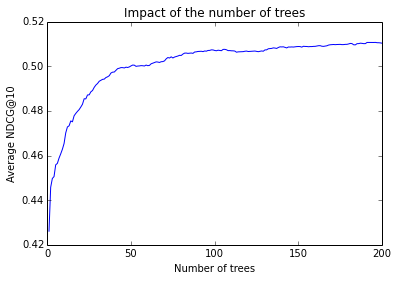

In [148]:
plot_ndcg_by_trees(gbr, X_test, y_test, qid_test)

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gbr2 = GradientBoostingRegressor(n_estimators=300, max_depth=3,
                                 learning_rate=0.1, loss='ls',
                                 random_state=1, verbose=1)
gbr2.fit(X_dev, y_dev)

      Iter       Train Loss   Remaining Time 
         1           0.6662          163.32m
         2           0.6556          131.63m
         3           0.6464          121.04m
         4           0.6388          117.25m
         5           0.6322          114.55m
         6           0.6268          112.25m
         7           0.6219          109.67m
         8           0.6174          108.07m
         9           0.6136          106.45m
        10           0.6105          104.90m
        20           0.5904           96.37m
        30           0.5807           92.51m
        40           0.5751           87.38m
        50           0.5712           81.67m
        60           0.5682           76.44m
        70           0.5659           71.63m
        80           0.5641           67.39m
        90           0.5626           63.37m
       100           0.5613          481.66m

In [ ]:
print_evaluation(gbr2, X_test, y_test, qid_test)

In [ ]:
plot_ndcg_by_trees(gbr2, X_test, y_test, qid_test)

In [ ]:
print_evaluation(gbr2, X_dev, y_dev, qid_dev)

In [32]:
%%time

from sklearn.ensemble import LambdaMART

lmart= LambdaMART(n_estimators=300, max_depth=3,
                  learning_rate=0.1, random_state=1, verbose=1)
lmart.fit(X_train_small, y_train_small, group=qid_train_small)

      Iter       Train Loss   Remaining Time 
         1           0.4105            8.01m
         2           0.4427            6.38m
         3           0.4445            5.84m
         4           0.4447            5.40m
         5           0.4441            5.18m
         6           0.4438            4.98m
         7           0.4529            4.84m
         8           0.4550            4.71m
         9           0.4557            4.60m
        10           0.4572            4.51m
        20           0.4659            4.00m
        30           0.4828            3.73m
        40           0.4927            3.53m
        50           0.5017            3.35m
        60           0.5069            3.20m
        70           0.5164            3.05m
        80           0.5205            2.91m
        90           0.5262            2.76m
       100           0.5303            2.63m
       200           0.5645            1.31m
       300           0.5844            0.00s
CPU times

In [33]:
print_evaluation(lmart, X_test, y_test, qid_test)

Prediction time: 2.294s
NDCG@5 score: 0.490
NDCG@10 score: 0.495
NDCG score: 0.737
R2 score: -1.423


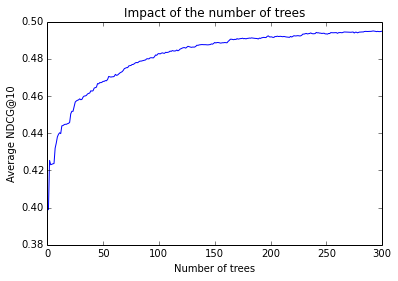

In [34]:
plot_ndcg_by_trees(lmart, X_test, y_test, qid_test)

In [35]:
print_evaluation(lmart, X_train_small, y_train_small, qid_train_small)

Prediction time: 0.844s
NDCG@5 score: 0.584
NDCG@10 score: 0.563
NDCG score: 0.756
R2 score: -1.441


In [48]:
%%time

lmart= LambdaMART(n_estimators=300, max_depth=3,
                  learning_rate=0.1, random_state=1, verbose=1)
lmart.fit(X_dev, y_dev, group=qid_dev)

      Iter       Train Loss   Remaining Time 
         1           0.4552          158.83m
         2           0.4555          123.79m
         3           0.4555          111.86m
         4           0.4561          105.25m
         5           0.4582          101.11m
         6           0.4637           98.34m
         7           0.4646           96.19m
         8           0.4651           94.57m
         9           0.4656           93.31m
        10           0.4666           92.22m
        20           0.4810           85.55m
        30           0.4917           81.51m
        40           0.5044           79.35m
        50           0.5120           76.18m
        60           0.5183           73.14m
        70           0.5231           70.31m
        80           0.5273           67.35m
        90           0.5301           64.28m
       100           0.5338           61.26m
       200           0.5490           30.89m
       300           0.5562            0.00s
CPU times

In [49]:
print_evaluation(lmart, X_test, y_test, qid_test)

Prediction time: 2.441s
NDCG@5 score: 0.522
NDCG@10 score: 0.525
NDCG score: 0.750
R2 score: -1.176


In [56]:
print_evaluation(lmart, X_dev, y_dev, qid_dev)

Prediction time: 9.917s
NDCG@5 score: 0.541
NDCG@10 score: 0.539
NDCG score: 0.757
R2 score: -1.149


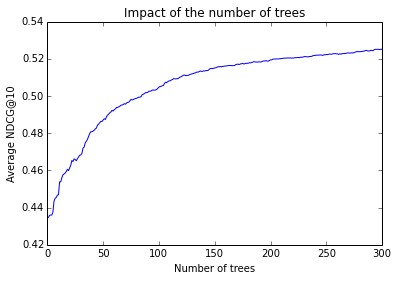

In [51]:
plot_ndcg_by_trees(lmart, X_test, y_test, qid_test)

## Growing Randomized Trees to predict relevance scores

In [29]:
from sklearn.ensemble import RandomForestRegressor

base_estimator = RandomForestRegressor(n_estimators=1, min_samples_split=10)
grower = EnsembleGrower(lb_view, base_estimator)

In [50]:
grower.launch(X_dev, y_dev, n_estimators=200, folder="web10k",
              dump_models=False)

Progress: 00% (000/200), elapsed: 0.413s


In [59]:
grower

Progress: 100% (200/200), elapsed: 1051.006s


In [57]:
#grower.wait()

In [60]:
%%time

rfr = grower.aggregate_model()
print("Number of trees: {}".format(len(rfr.estimators_)))

Number of trees: 200
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.03 ms


In [61]:
print_evaluation(rfr, X_test, y_test, qid_test)

Prediction time: 21.488s
NDCG@5 score: 0.528
NDCG@10 score: 0.531
NDCG score: 0.751
R2 score: 0.190


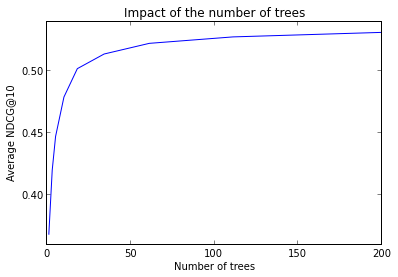

In [62]:
plot_ndcg_by_trees(rfr, X_test, y_test, qid_test)

Evaluation of the overfitting of the ensemble:

In [63]:
print_evaluation(rfr, X_train_medium, y_train_medium, qid_train_medium)

Prediction time: 11.140s
NDCG@5 score: 0.949
NDCG@10 score: 0.953
NDCG score: 0.963
R2 score: 0.806


## Comparing with a baseline linear regression models (with different optimizers and input scaling)

In [30]:
%time lr = LinearRegression().fit(X_dev, y_dev)

CPU times: user 25.4 s, sys: 1.47 s, total: 26.9 s
Wall time: 19.9 s


In [33]:
%time y_test_lr = lr.predict(X_test)

CPU times: user 136 ms, sys: 96.5 ms, total: 232 ms
Wall time: 214 ms


In [34]:
print_evaluation(lr, X_test, y_test, qid_test)

Prediction time: 0.221s
NDCG@5 score: 0.433
NDCG@10 score: 0.450
NDCG score: 0.722
R2 score: 0.127


Evaluate overfitting by comparing with training set:

In [40]:
print_evaluation(lr, X_dev, y_dev, qid_dev)

Prediction time: 1.035s
NDCG@5 score: 0.432
NDCG@10 score: 0.451
NDCG score: 0.722
R2 score: 0.131


Interestingly enough, a slight overfitting of the training set from a regression standpoint (higher r2 score) does not seem to cause overfitting from a ranking standpoint. This would have to be checked with cross-validation though.

Let's evaluate the impact of imput feature normalization:

In [47]:
%%time

nlr = LinearRegression(normalize=True).fit(X_dev, y_dev)

CPU times: user 27.2 s, sys: 2.62 s, total: 29.8 s
Wall time: 23.9 s


In [49]:
print_evaluation(nlr, X_test, y_test, qid_test)

Prediction time: 0.235s
NDCG@5 score: 0.434
NDCG@10 score: 0.450
NDCG score: 0.722
R2 score: 0.127


In [53]:
%%time

nlr = LinearRegression(normalize=True).fit(X_train_small, y_train_small)

CPU times: user 1.59 s, sys: 44.5 ms, total: 1.63 s
Wall time: 1.22 s


In [54]:
print_evaluation(nlr, X_test, y_test, qid_test)

Prediction time: 0.228s
NDCG@5 score: 0.431
NDCG@10 score: 0.448
NDCG score: 0.719
R2 score: 0.098


In [55]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_small_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

In [96]:
%%time

sgdlr = SGDRegressor(alpha=1e-7, learning_rate='constant', eta0=1e-5, n_iter=50).fit(X_train_small_scaled, y_train_small)

CPU times: user 1.26 s, sys: 15 ms, total: 1.27 s
Wall time: 1.27 s


In [98]:
print_evaluation(sgdlr, X_test_scaled, y_test, qid_test)

Prediction time: 0.250s
NDCG@5 score: 0.433
NDCG@10 score: 0.448
NDCG score: 0.720
R2 score: 0.118


## Comparing with a classification to NDCG ranking reduction models

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

In [105]:
def proba_to_relevance(probas):
    """MCRank-like reduction of classification proba to DCG predictions"""
    rel = np.zeros(probas.shape[0], dtype=np.float32)
    for i in range(probas.shape[1]):
        rel += i * probas[:, i]
    return rel
        
        
class ClassificationRanker(RegressorMixin):
    
    def __init__(self, base_estimator=None):
        self.base_estimator = base_estimator
        
    def fit(self, X, y):
        self.estimator_ = clone(self.base_estimator)
        self.scaler_ = StandardScaler()
        X = self.scaler_.fit_transform(X)
        self.estimator_.fit(X, y)
        
    def predict(self, X):
        X_scaled = self.scaler_.transform(X)
        probas = self.estimator_.predict_proba(X_scaled)
        return proba_to_relevance(probas)

In [44]:
%%time

logr = ClassificationRanker(LogisticRegression(C=1000))
logr.fit(X_train_small, y_train_small)

CPU times: user 20min 29s, sys: 2.97 s, total: 20min 32s
Wall time: 8h 30min 23s


In [45]:
print_evaluation(logr, X_test, y_test, qid_test)

Prediction time: 1.326s
NDCG@5 score: 0.440
NDCG@10 score: 0.456
NDCG score: 0.724
R2 score: 0.126


In [146]:
%%time

from sklearn.linear_model import SGDClassifier

sgdlogr = SGDClassifier(loss='modified_huber', alpha=1e-8, n_iter=200, learning_rate='constant', eta0=1e-6, n_jobs=-1)
sgdlogrr = ClassificationRanker(sgdlogr)
sgdlogrr.fit(X_train_small_scaled, y_train_small)

CPU times: user 860 ms, sys: 993 ms, total: 1.85 s
Wall time: 13.9 s


In [147]:
print_evaluation(sgdlogrr, X_test_scaled, y_test, qid_test)

Prediction time: 0.564s
NDCG@5 score: 0.440
NDCG@10 score: 0.454
NDCG score: 0.723
R2 score: 0.127


In [122]:
%%time

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, max_features=20, min_samples_split=5,
                            random_state=1, n_jobs=-1)
rfr = ClassificationRanker(rfc)
rfr.fit(X_train_small, y_train_small)

CPU times: user 3min 34s, sys: 1.3 s, total: 3min 36s
Wall time: 1min


In [123]:
print_evaluation(rfr, X_test, y_test, qid_test)

Prediction time: 5.751s
NDCG@5 score: 0.468
NDCG@10 score: 0.477
NDCG score: 0.730
R2 score: 0.138


In [124]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=1)
gbr = ClassificationRanker(gbc)
gbr.fit(X_train_small, y_train_small)

CPU times: user 5min 52s, sys: 1.45 s, total: 5min 54s
Wall time: 5min 54s


In [125]:
print_evaluation(gbr, X_test, y_test, qid_test)

Prediction time: 5.175s
NDCG@5 score: 0.500
NDCG@10 score: 0.506
NDCG score: 0.743
R2 score: 0.149


In [111]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

etc = ClassificationRanker(ExtraTreesClassifier(n_estimators=200, random_state=1, n_jobs=-1))
etc.fit(X_train_small, y_train_small)

CPU times: user 2min 5s, sys: 1.8 s, total: 2min 7s
Wall time: 36.4 s


In [112]:
print_evaluation(etc, X_test, y_test, qid_test)

Prediction time: 7.620s
NDCG@5 score: 0.433
NDCG@10 score: 0.447
NDCG score: 0.719
R2 score: 0.124


## Introspecting the distribution of relevance scores predictions

In [66]:
subset = np.random.permutation(y_test.shape[0])[:10000]

(-2, 5)

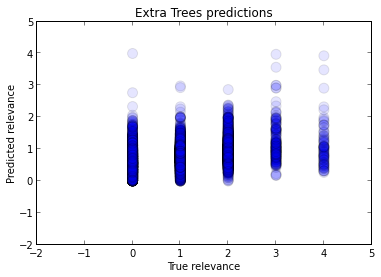

In [67]:
plt.title('Extra Trees predictions')
plt.scatter(y_test[subset], y_test_etr[subset], alpha=0.1, s=100)
plt.xlabel('True relevance')
plt.ylabel('Predicted relevance')
plt.ylim(-2, 5)
plt.xlim(-2, 5)

(-2, 5)

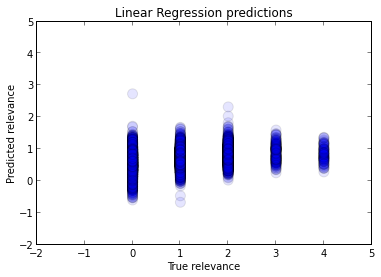

In [68]:
plt.title('Linear Regression predictions')
plt.scatter(y_test[subset], y_test_lr[subset], alpha=0.1, s=100)
plt.xlabel('True relevance')
plt.ylabel('Predicted relevance')
plt.ylim(-2, 5)
plt.xlim(-2, 5)

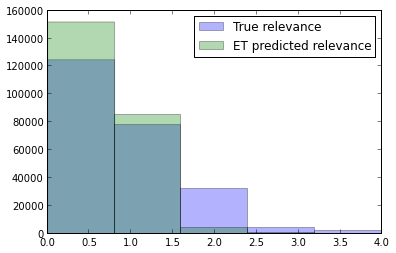

In [69]:
plt.hist(y_test, bins=5, alpha=.3, color='b', label='True relevance')
plt.hist(y_test_etr, bins=5, alpha=.3, color='g', label='ET predicted relevance')
plt.legend(loc='best')

For each query, count the number of results with rank 0, 1, 2, 3 or 4.

In [70]:
unique_qids_test = np.unique(qid_test)
for qid in unique_qids_test[:5]:
    qids = y_test[qid_test == qid].astype(np.int)
    print(np.bincount(qids, minlength=5))

[45 54 31  8  0]
[59 25  8  2  0]
[52 20  9  2  3]
[97 45  2  2  2]
[32 56 24  7  4]
